# Assignment 3: Reinforcement Learning Pipeline in Practice


*CS260R: Reinforcement Learning. Department of Computer Science at University of California, Los Angeles.
Course Instructor: Professor Bolei ZHOU. Assignment author: Zhenghao PENG.*

-----


## TODOs

You need to implement all TODOs in the python files. Then run all cells in this notebook and plot your results. 

Note:

1. You can run the training in your terminal and selectively run the visualization and evaluation cells in this notebook.
2. You need to remove the "REFERENCE" in figures.
3. You don't need to exactly reproduce our results, but your implementation should show the similar progress in training.
4. We use multi-processing to enable asynchronous data sampling. Therefore in many places the tensors have shape `[num_steps, num_envs, num_feat]`. This means that `num_envs` environments are running concurrently and each of them samples a fragment of trajectory with length `num_steps`. There are totally `num_steps*num_envs` transitions are generated in each training iteration.
5. Each process can only have a single MetaDrive environment.
6. The jupyter notebook is used for tutorial and visualization. It is optional for you to use the notebook to call `train_ppo|td3.py` and `eval_ppo|td3.py`. But we expect to see figures, results and visualization in this notebook.




We are expecting the following figures, results and visualization:

1. TD3 in Pendulum-v1: learning curve (2.1)
2. TD3 in MetaDrive-Tut-Hard-v0: learning curve (2.2), evaluation result (2.3)
3. PPO in CartPole-v1: learning curve (3.1)
4. PPO in MetaDrive-Tut-Hard-v0: learning curve (3.2), evaluation result (3.3), visualization (3.4)


### File structure

You need to pay attention to the files below:

TD3: 

* `core/td3_trainer.py` - File which can be directly run to train TD3. **Please implement TD3 here.**

PPO:

* `train_ppo.py` - Train scripts for PPO in CartPole-v0 and MetaDrive. **Please implement TODO in this file.**
* `core/ppo_trainer.py` - PPO algorithm. **Please implement `compute_action` and `compute_loss`.**
* `core/buffer.py` - Supporting data structure for PPO (GAE is implemented here). **Please implement `compute_returns` for PPO.**

Common:

* `assignment3.ipynb` - Useful jupyter notebook to walk you through the whole assignment. You need to plot figures and results here.
* `[train|eval]_[ppo|td3].py` - The entries to training and evaluation.


### Deliverables

1) The exported **PDF file** of the this notebook.
2) Compress all files in the `assignment3` folder and prepare a **ZIP file**. No `.rar` or other format is allowed.

You need to submit **both the ZIP file and the PDF file** to bruinlearn. The PDF file goes to gradescope tab and the 
ZIP file goes to the assignment tab.



### Colab supporting

Though we use multiple files to implement algorithms, we can still leverage Colab for free computing resources. 

* Step 1: Create a folder in your Google Drive root named `cs260r`
* Step 2: Upload the files in `assignment3` folder such as `train_ppo.py` and the folder `core` to the newly created `cs260r` folder in your Google Drive.
* Step 3: Run the last cell in Demo 1 (pay attention to the code we mount the colab to your google drive).




## Demo 1: Setup dependencies

In [1]:
!pip install torch

# Install MetaDrive, a lightweight driving simulator
!pip install git+https://github.com/metadriverse/metadrive

# Test whether MetaDrive is properly installed. No error means the test is passed.
!python -m metadrive.examples.profile_metadrive --num-steps 100

!pip install pandas scipy seaborn tabulate pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 7.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 14.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 12.0 MB/s eta 0:00:00
  Cloning https://github.com/metadriverse/metadrive to /private/var/folders/3z/6sbxmhbx3790n_dxjdb3s8kw0000gn/T/pip-req-build-3mi9zoa3
  Running command git clone --filter=blob:none --quiet https://github.com/metadriverse/metadrive /private/var/folders/3z/6sbxmhbx3790n_dxjdb3s8kw0000gn/T/pip-req-build-3mi9zoa3
  Resolved https://github.com/metadriverse/metadrive to commit bb0a0c64f776769340b7daff81c154c04c8aa3a7
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.6 MB/s eta 0:00:00

In [2]:
import os

try:
    from google.colab import drive
    drive.mount('/content/gdrive')

    DRIVE_PATH = '/content/gdrive/My Drive/cs260r'  # No need for backslash
    if not os.path.exists(DRIVE_PATH):
        !mkdir -p "$DRIVE_PATH"  # Ensure the folder exists

    # Create a symlink to avoid issues with spaces in 'My Drive'
    SYM_PATH = '/content/cs260r'
    if not os.path.exists(SYM_PATH):
        !ln -s "$DRIVE_PATH" "$SYM_PATH"

    running_in_colab = True
    
    # We already mounted in our google drive.
    # Enter the foler where you put files in:
    %cd '/content/cs260r'

except ModuleNotFoundError:
    running_in_colab = False
    print("I guess you are running locally. If you get this message in Colab, something is wrong.")

print("\nCurrent working directory:")
!pwd

print("\nWhat files are there:")
!ls

I guess you are running locally. If you get this message in Colab, something is wrong.

Current working directory:
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3

What files are there:
README.md         core              format.sh         vis.py
__init__.py       eval_ppo.py       train_ppo.py
assignment3.ipynb eval_td3.py       train_td3.py


## Demo 2: Train a TD3 agent

Spinning Up tutorial provides great explaination on TD3 algorithm:
https://spinningup.openai.com/en/latest/algorithms/td3.html

Please implement all TODOs in `core/td3_trainer.py` and `train_td3.py`.

### Demo 2.1: Train TD3 agent in Pendulum-v1

In [10]:
!python train_td3.py \
--env-id Pendulum-v1 \
--log-dir Pendulum-v1 \
--max-steps 50000 \
--start-steps 1000 \
--lr 1e-3

/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
Training Step:   2%|▍                   | 1037/50000 [00:00<00:04, 10292.20it/s]
 ===== TD3 Training Step 1199 =====:
  actor_loss: 8.157340049743652
  critic_loss: 0.5673727989196777
  current_q1: -8.351524353027344
  current_q2: -8.396295547485352
  episode_reward: -1215.3127863964728
  frame_per_second: 3092
  log_dir: Pendulum-v1
  reward: -5.997926712036133
  target_q: -8.331493377685547
  total_episodes: 6
  total_steps: 1199
  total_time: 0.38770198822021484

Trainer is saved at <Pendulum-v1/td3>. Progress is saved at <Pendulum-v1/td3/progress.csv>.
Training Step:   4%|▉                     | 2067/50000 [00:01<00:51, 927.07it/s]
 ===== TD3 Training Step 2199 =====:
  actor_loss: 23.395008087158203
  critic_loss: 3.0279648303985596
  current_q1: -23.607635498046875
  current_q2: -23.601598739624023
  episode_reward: -1347.5314441903226
  frame_per_second: 1016
  log_dir: Pendulum-v1
  reward: -7.081517219543457


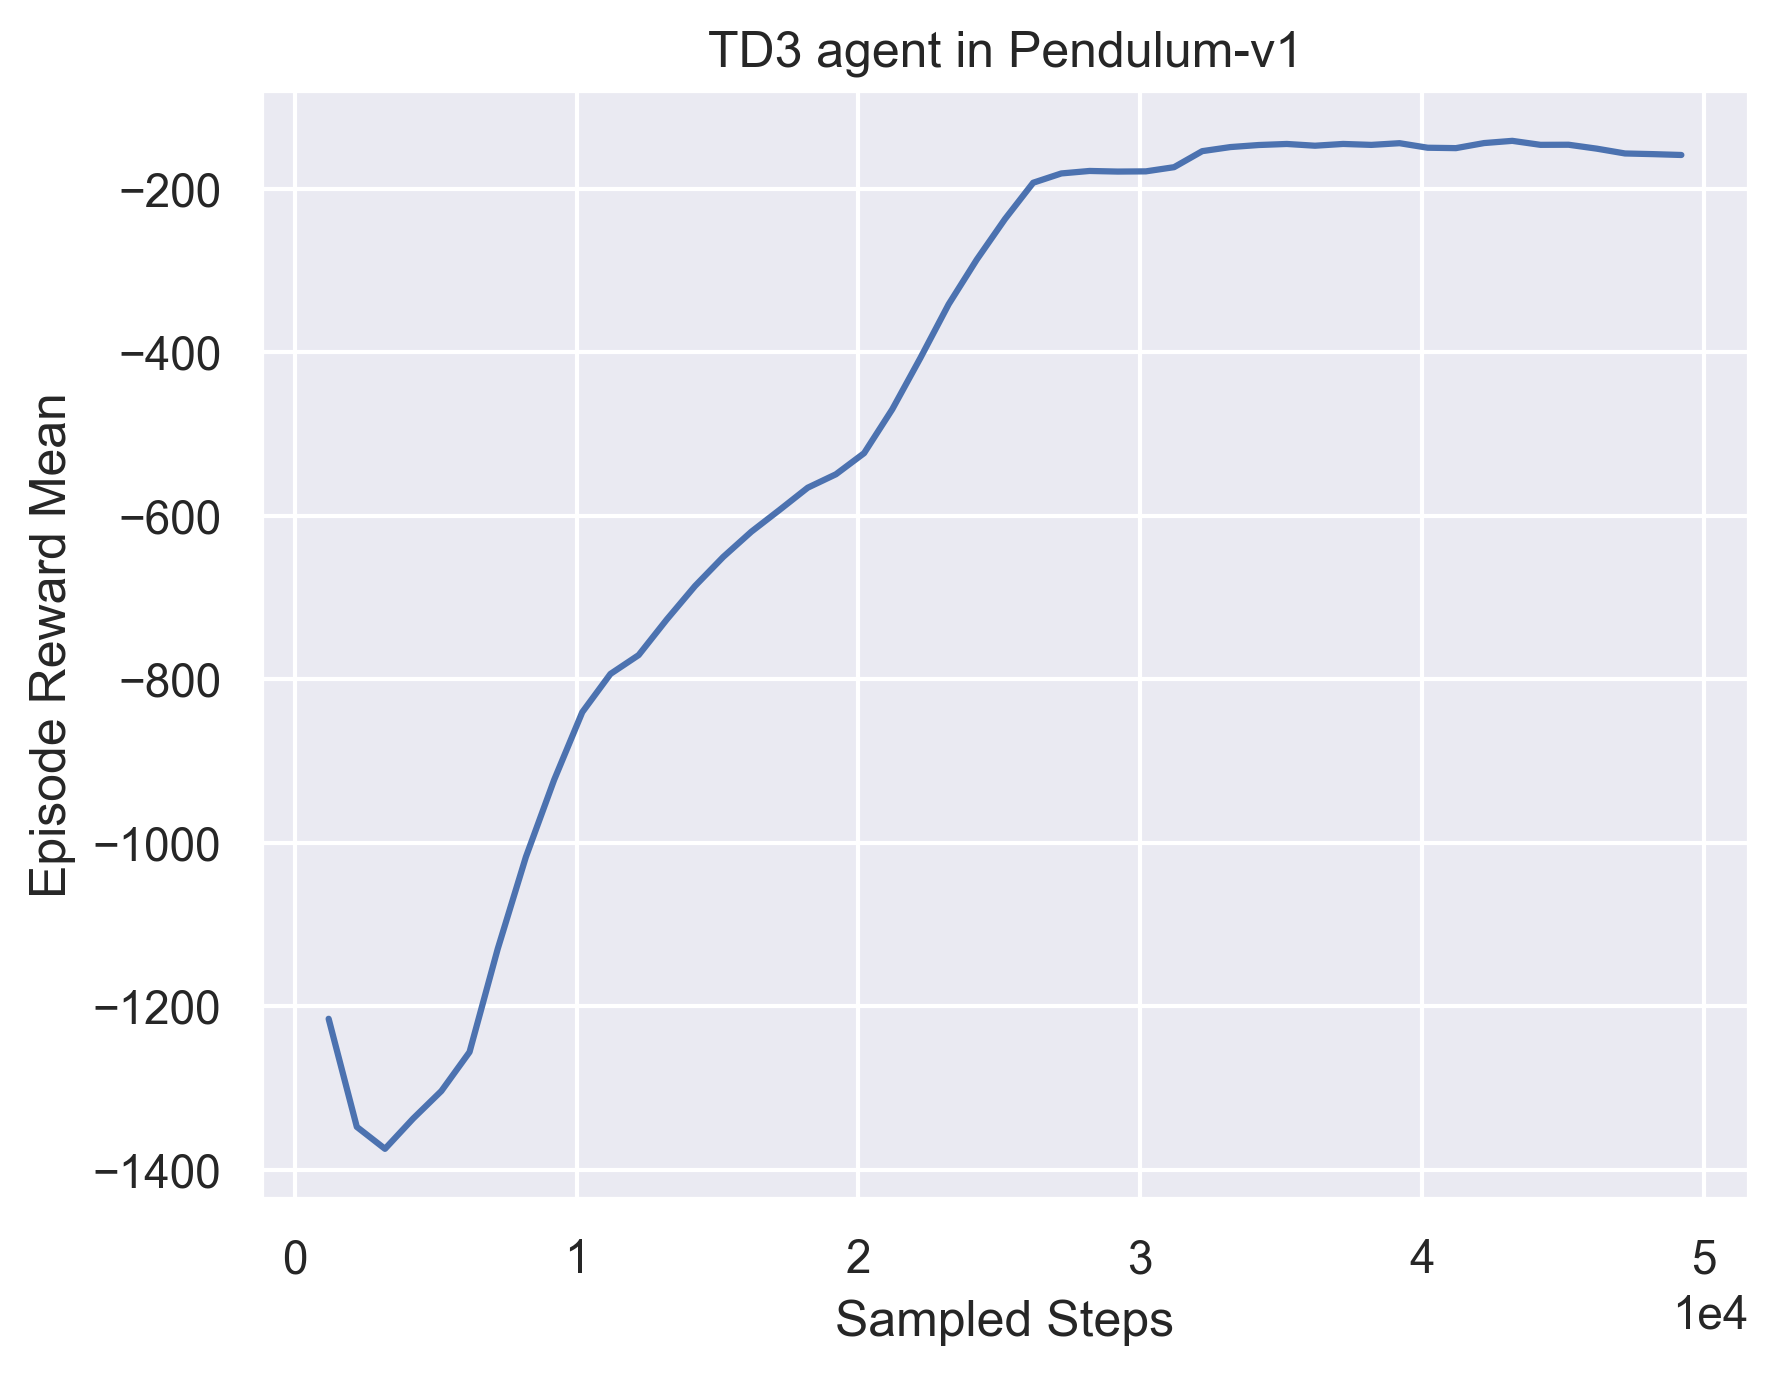

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

progress = pd.read_csv("Pendulum-v1/td3/progress.csv")
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=progress,
    x="total_steps",
    y="episode_reward"
)
ax.set_title("TD3 agent in Pendulum-v1")
ax.set_ylabel("Episode Reward Mean")
ax.set_xlabel("Sampled Steps")

# TODO: You should remove this line in your code.
# ax.annotate("REFERENCE", (0, -500), size=50, alpha=0.05)

ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

plt.savefig('pendulum-td3.png', format='png', dpi=300, bbox_inches="tight")


### Demo 2.2: Train TD3 agent in MetaDrive-Tut-Hard-v0


In [13]:
!python train_td3.py \
--env-id MetaDrive-Tut-Hard-v0 \
--log-dir MetaDrive-Tut-Hard-v0 \
--max-steps 100_000


/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
Successfully registered MetaDrive environments:  ['MetaDrive-Tut-Easy-v0', 'MetaDrive-Tut-Hard-v0', 'MetaDrive-Tut-1Env-v0', 'MetaDrive-Tut-5Env-v0', 'MetaDrive-Tut-10Env-v0', 'MetaDrive-Tut-20Env-v0', 'MetaDrive-Tut-50Env-v0', 'MetaDrive-Tut-100Env-v0', 'MetaDrive-Tut-Test-v0']
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 1000
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[INFO] Start Scenario Index: 1000, Num Scenarios : 20
Training Step:   2%|▍                   | 1933/100000 [00:01<01:32, 1058.69it/s][INFO] Episode ended! Scenario Index: 1018 Reason: max step 

 ===== TD3 Training Step 1999 =====:
  actor_loss: .nan
  critic_loss: .nan
  episode_reward: 8.119108930317438
  frame_per_second: 1060
  log_dir: Met

The log contains these keys:  Index(['Unnamed: 0', 'log_dir', 'frame_per_second', 'episode_reward',
       'total_steps', 'total_episodes', 'total_time', 'target_q', 'actor_loss',
       'critic_loss', 'success_rate', 'current_q1', 'current_q2', 'reward'],
      dtype='object')


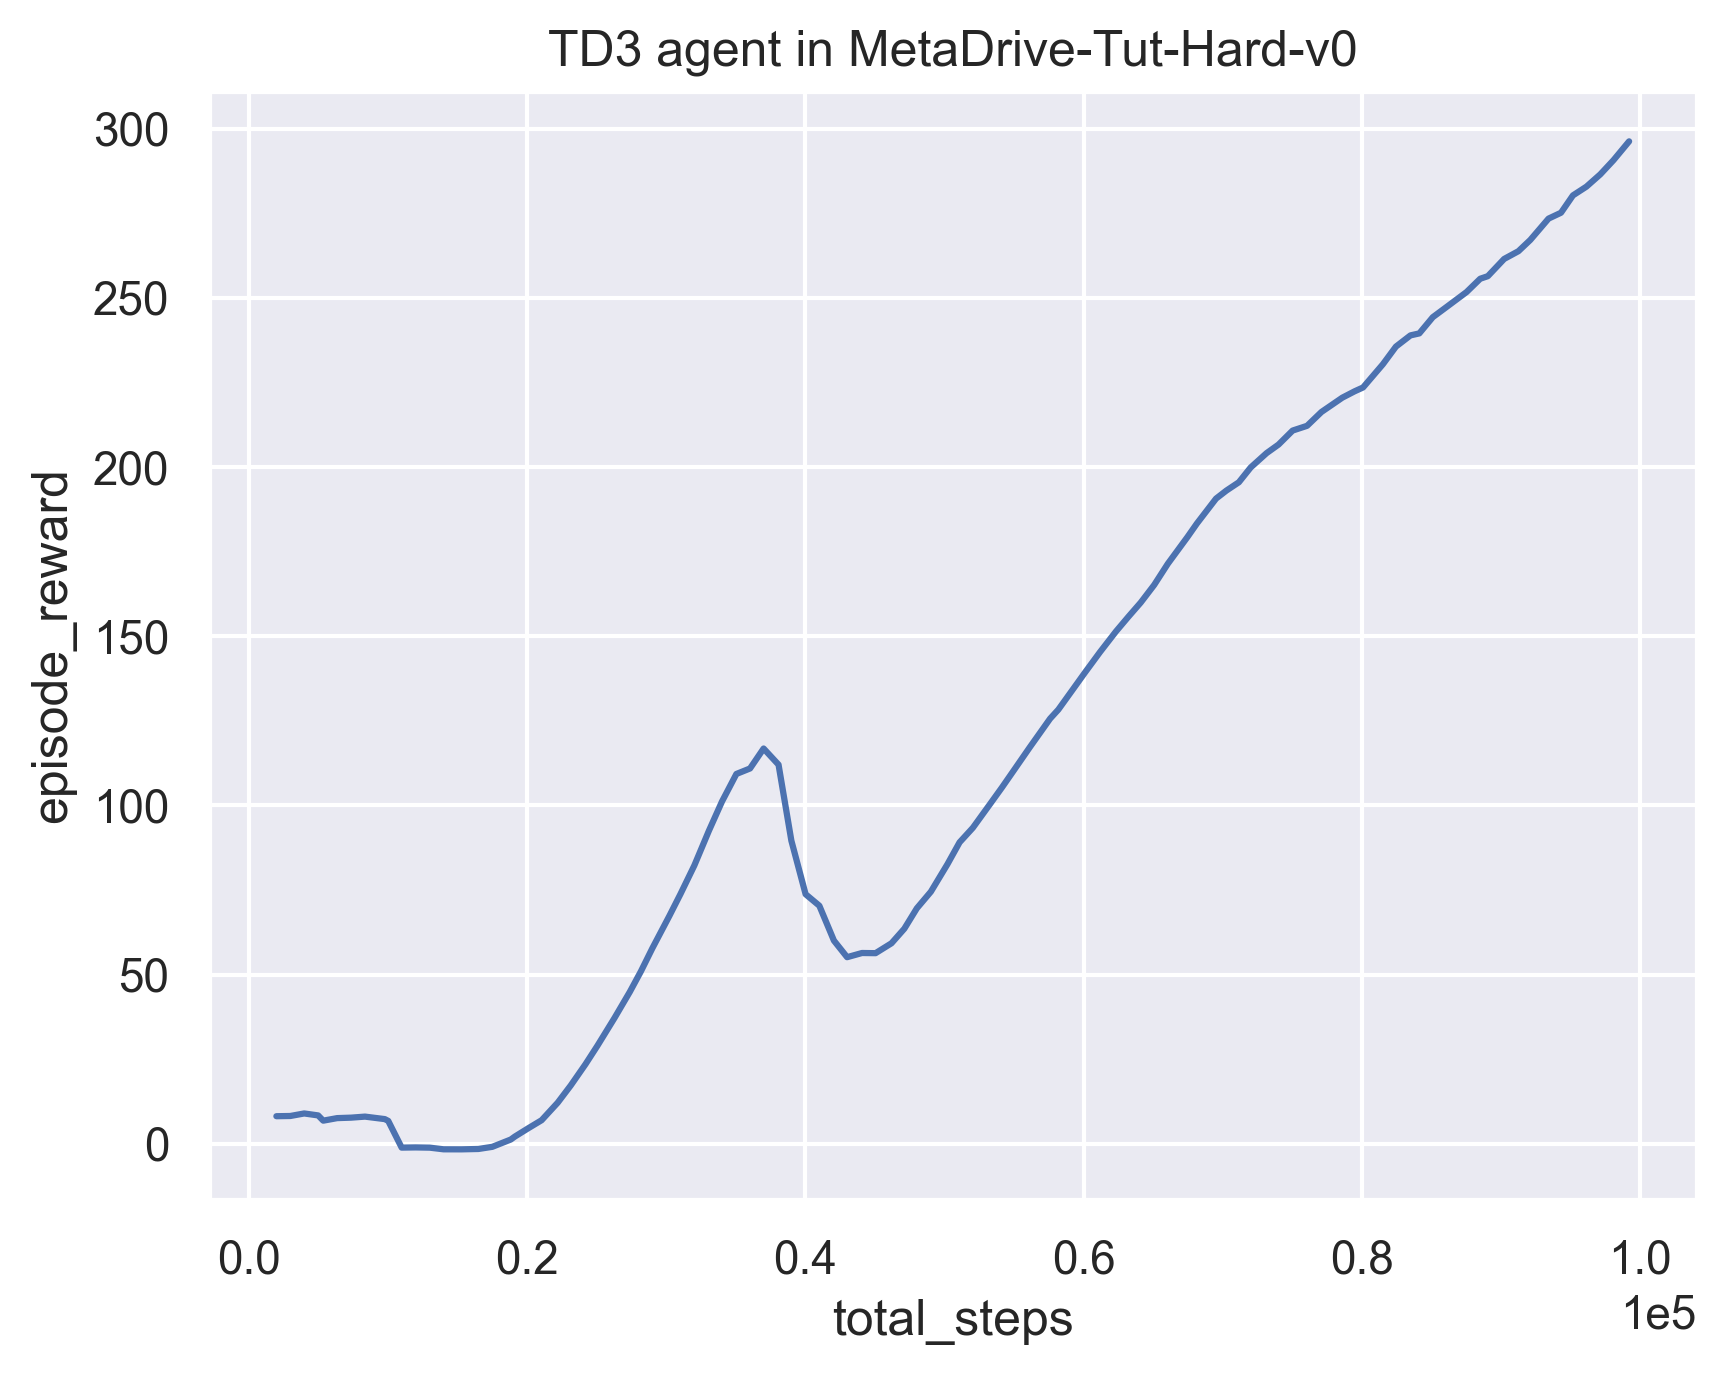

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

progress = pd.read_csv("MetaDrive-Tut-Hard-v0/td3/progress.csv")
print("The log contains these keys: ", progress.keys())
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=progress,
    x="total_steps",
    y="episode_reward"
)
ax.set_title("TD3 agent in MetaDrive-Tut-Hard-v0")

ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

# TODO: You should remove this line in your code.
# ax.annotate("REFERENCE", (0, 200), size=50, alpha=0.05)

plt.savefig('metadrive-hard-td3.png', format='png', dpi=300, bbox_inches="tight")


### Demo 2.3: Evaluate TD3 in MetaDrive

In [16]:
!python eval_td3.py \
--env-id="MetaDrive-Tut-Hard-v0" \
--log-dir="MetaDrive-Tut-Hard-v0/td3"


/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
Successfully registered MetaDrive environments:  ['MetaDrive-Tut-Easy-v0', 'MetaDrive-Tut-Hard-v0', 'MetaDrive-Tut-1Env-v0', 'MetaDrive-Tut-5Env-v0', 'MetaDrive-Tut-10Env-v0', 'MetaDrive-Tut-20Env-v0', 'MetaDrive-Tut-50Env-v0', 'MetaDrive-Tut-100Env-v0', 'MetaDrive-Tut-Test-v0']
/opt/anaconda3/envs/cs260r/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment MetaDrive-Tut-Easy-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/cs260r/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment MetaDrive-Tut-Hard-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/cs260r/lib/python3.11/site-packages/gymnasium/envs/regis

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

td3_eval = pd.read_csv("MetaDrive-Tut-Hard-v0/td3/eval_results.csv")
print("TD3 agent average reward: {}".format(td3_eval.rewards.mean()))

TD3 agent average reward: 374.2815343973227


## Demo 3: Train a PPO agent

You need to finish `core/ppo_trainer.py`, `core/buffer.py` and `train_ppo.py`.

Here we use GAE [1] (Generalized Advantage Estimation) to estimate the advantage. This technique is implemented in `PPORolloutStorage.compute_returns` in `core/buffer.py`. Concretely, we estimate the advantage of current state $t$ via:

$$\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$$

$$A^{GAE}_t = \sum_{l=0}^{\infty} (\gamma \lambda) ^ l \delta_{t+l}$$

wherein $V$ is the state value function, $\lambda$ is a hyper-parameter defined in `PPOConfig["gae_lambda"]`.

You can find that when $\lambda = 0$, the GAE estimates advantage in an one-step TD manner. When $\lambda = 1$, the GAE reduces to Monte Carlo Estimation of the state value. Therefore by varying the $\lambda$, we can adjust the trade-off between the accuracy of the estimation, namely the bias, and the variance of the advantage.

[1]: Schulman, John , et al. "High-Dimensional Continuous Control Using Generalized Advantage Estimation." (2015).

### Demo 3.1 Train and draw the learning curve of PPO in CartPole

In [19]:
!python train_ppo.py \
--env-id CartPole-v1 \
--log-dir CartPole-v1 \
--num-envs 10 \
--max-steps 300000

/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
Start training!
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
  0%|                                                | 0/300000 [00:00<?, ?it/s]
 ===== ppo Training Iteration 0 =====:
  adv_mean: 8.434235572814941
  entropy: 0.6851770173280667
  episode_reward: 23.13
  frame_per_second: 1

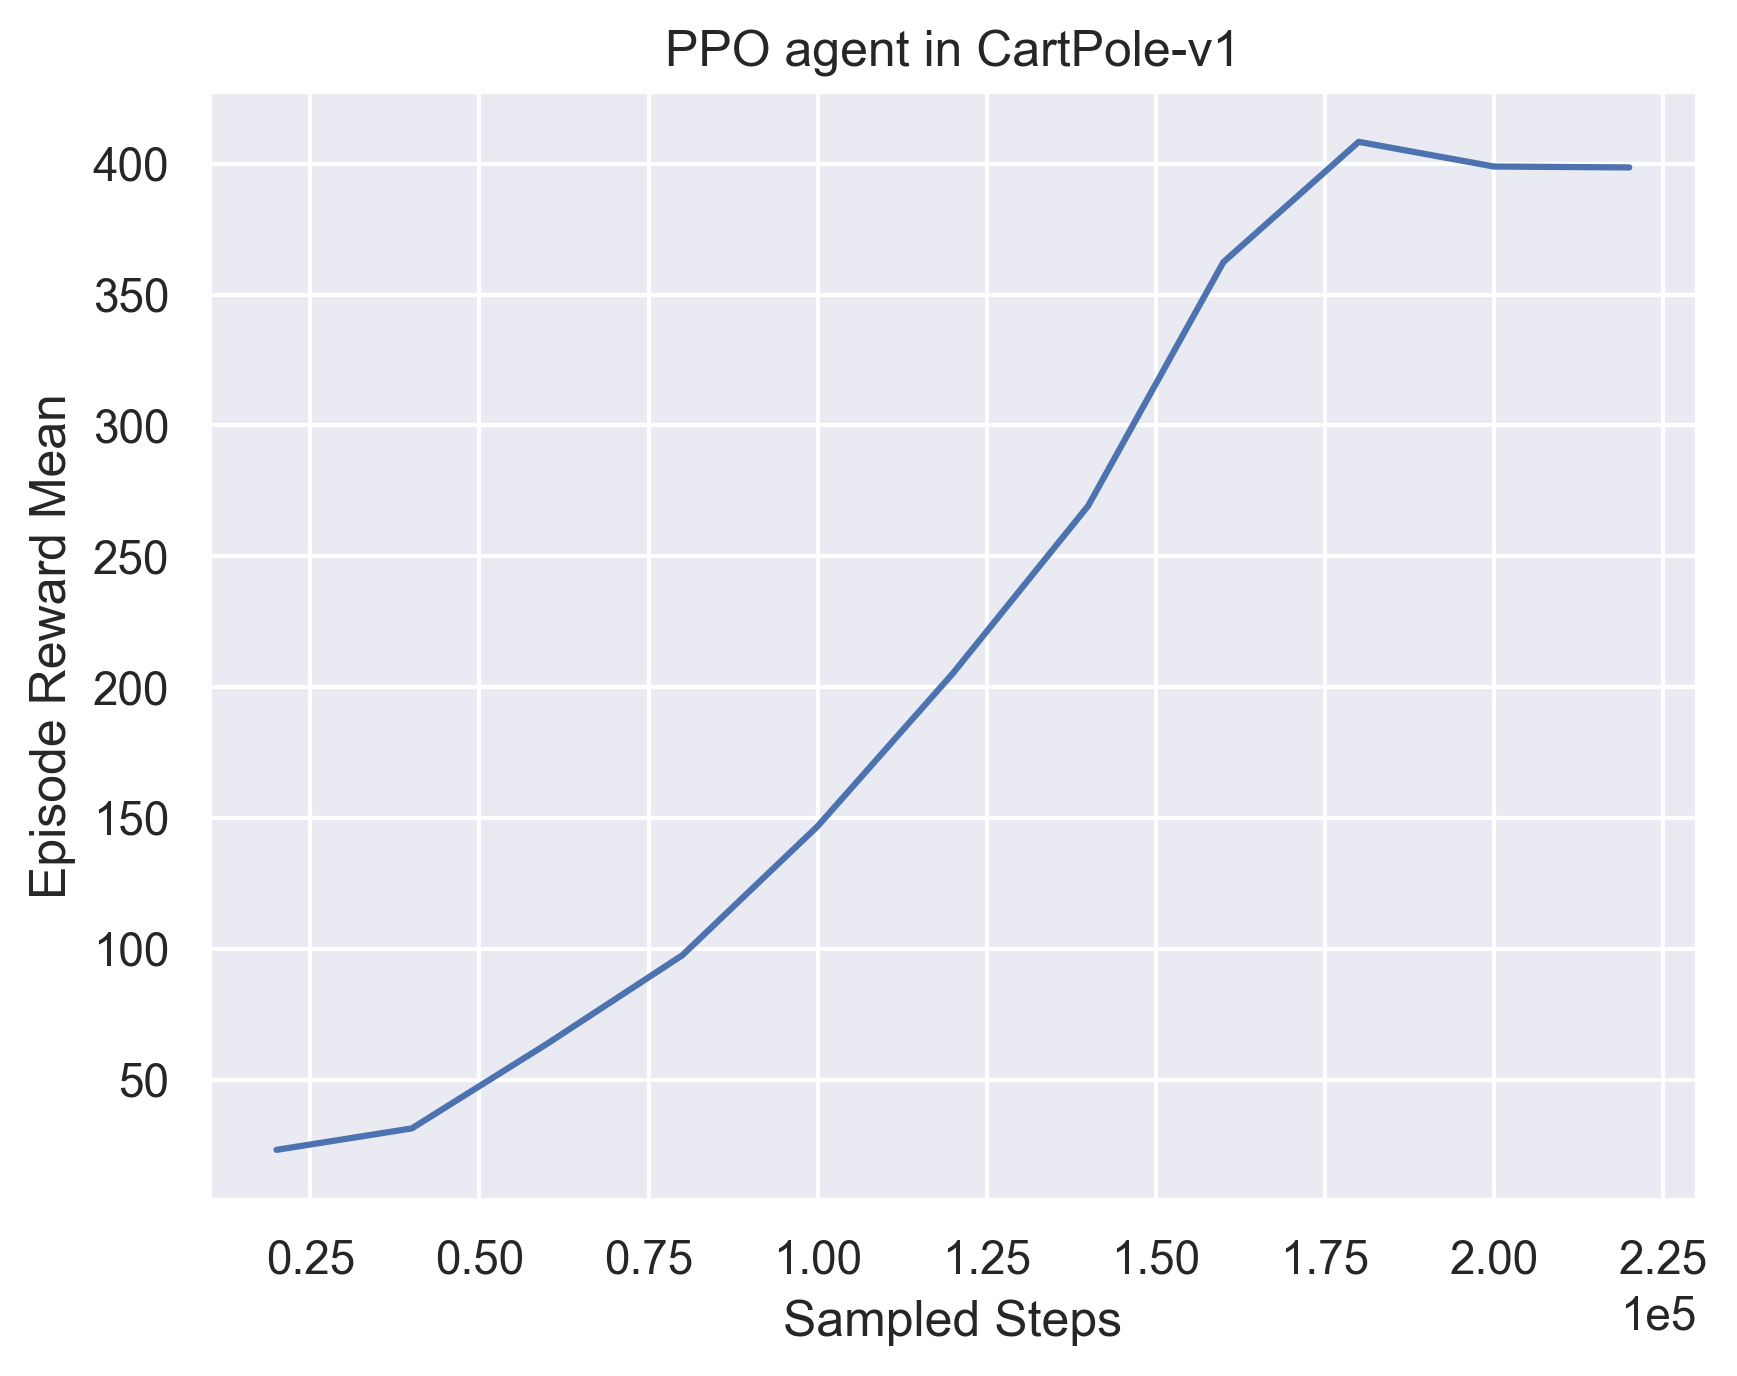

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ppo_progress = pd.read_csv("CartPole-v1/ppo/progress.csv")
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=ppo_progress,
    x="total_steps",
    y="episode_reward"
)
ax.set_title("PPO agent in CartPole-v1")
ax.set_ylabel("Episode Reward Mean")
ax.set_xlabel("Sampled Steps")

# You should remove this line in your code:
# ax.annotate("REFERENCE", (ax.get_xlim()[1] / 10, ax.get_ylim()[1]*6/10), size=50, alpha=0.05)

ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

plt.savefig('cartpole-ppo.png', format='png', dpi=300, bbox_inches="tight")


### Demo 3.2: Train and play with the PPO agent in MetaDrive Hard Env.

In [3]:
!python train_ppo.py \
  --env-id MetaDrive-Tut-Hard-v0 \
  --log-dir MetaDrive-Tut-Hard-v0 \
  --num-envs 10 \
  --max-steps 1_000_000

/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
Successfully registered MetaDrive environments:  ['MetaDrive-Tut-Easy-v0', 'MetaDrive-Tut-Hard-v0', 'MetaDrive-Tut-1Env-v0', 'MetaDrive-Tut-5Env-v0', 'MetaDrive-Tut-10Env-v0', 'MetaDrive-Tut-20Env-v0', 'MetaDrive-Tut-50Env-v0', 'MetaDrive-Tut-100Env-v0', 'MetaDrive-Tut-Test-v0']
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 1000
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core


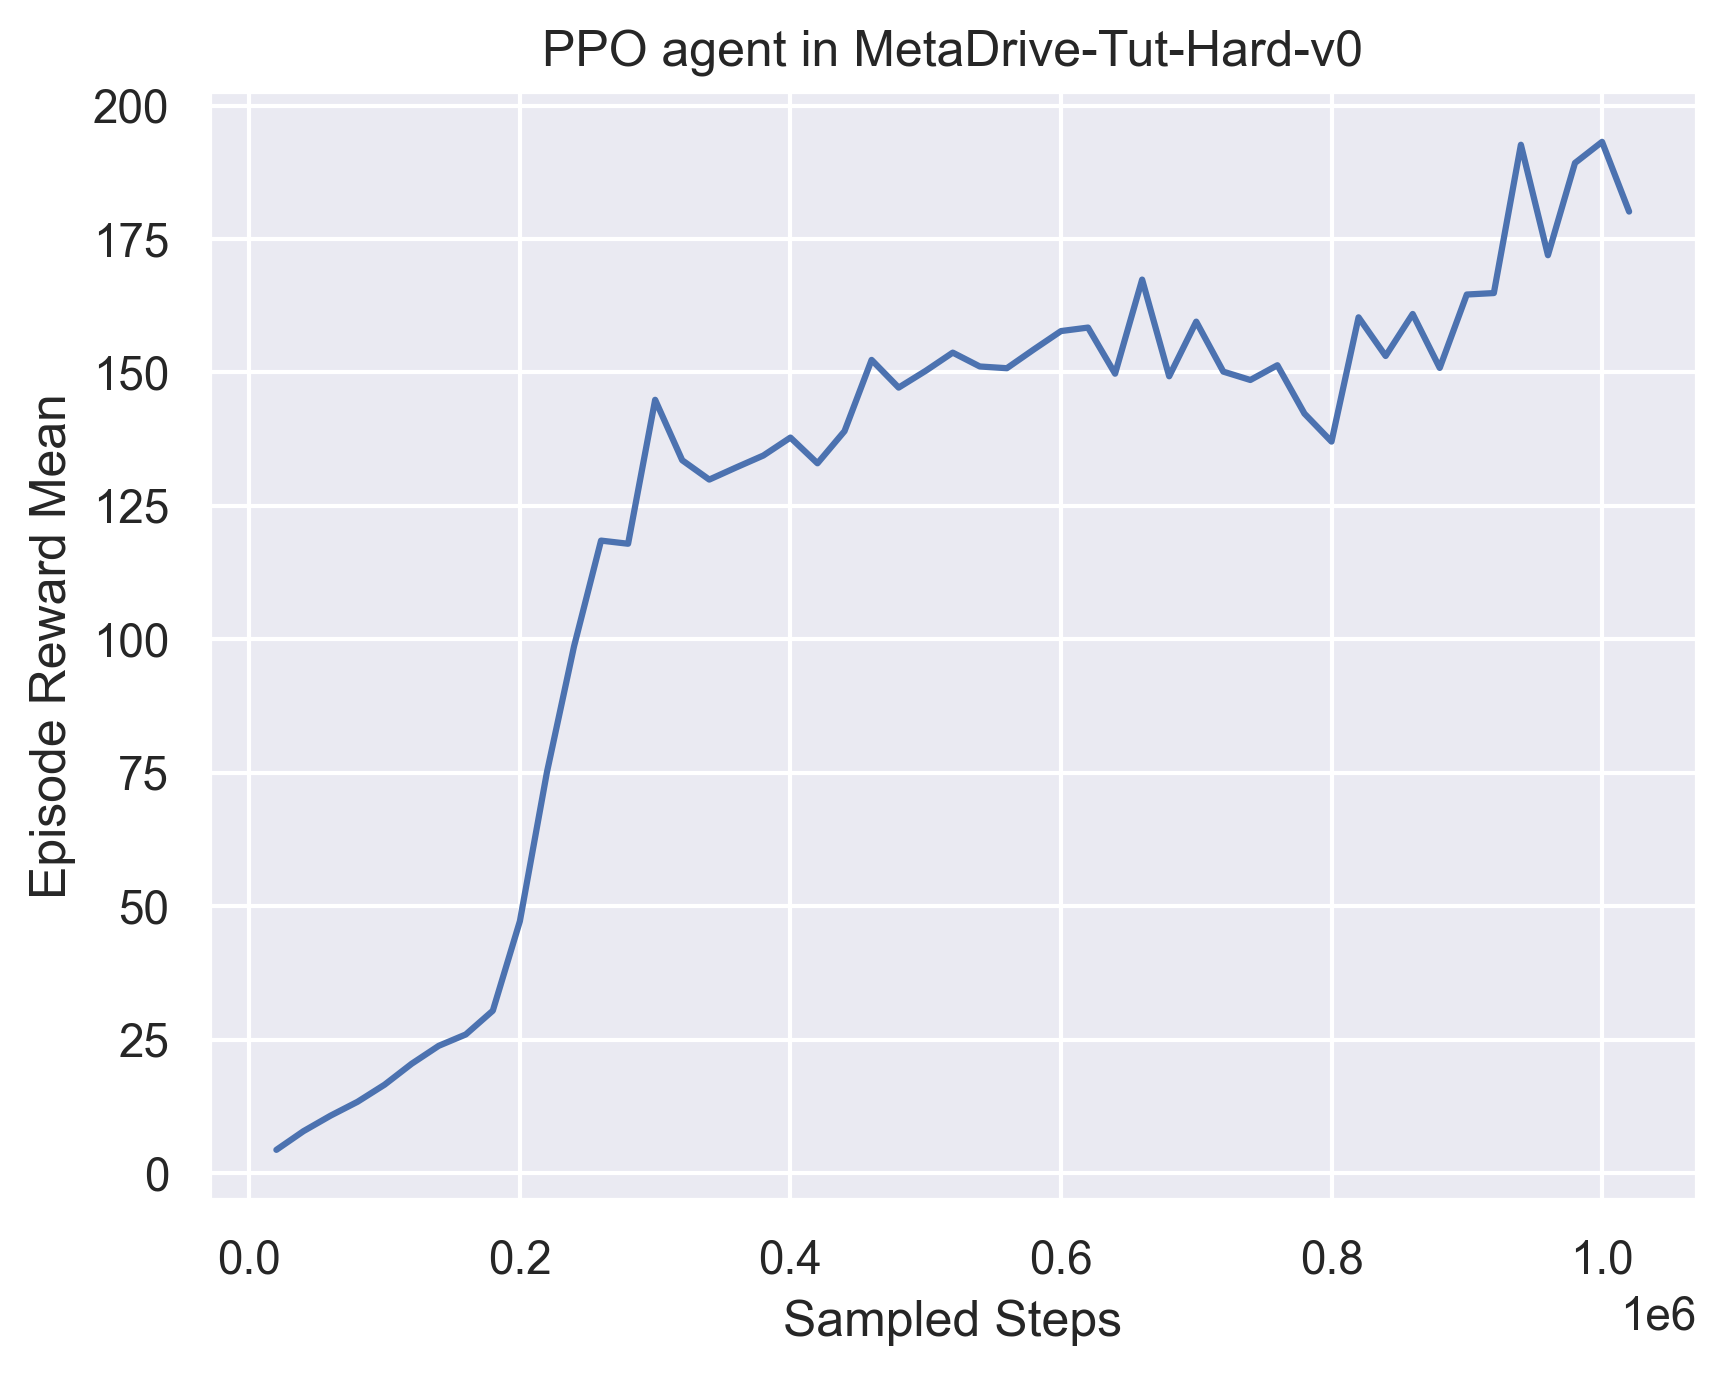

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ppo_progress = pd.read_csv("MetaDrive-Tut-Hard-v0/ppo/progress.csv")
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=ppo_progress,
    x="total_steps",
    y="episode_reward"
)
ax.set_title("PPO agent in MetaDrive-Tut-Hard-v0")
ax.set_ylabel("Episode Reward Mean")
ax.set_xlabel("Sampled Steps")

ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

# TODO: Remove this line
# ax.annotate("REFERENCE", (0, ax.get_ylim()[1]*6/10), size=50, alpha=0.05)

plt.savefig('metadrive-hard-ppo.png', format='png', dpi=300, bbox_inches="tight")


### Demo 3.3: Evaluate PPO in MetaDrive

In [8]:
!python eval_ppo.py \
  --env-id="MetaDrive-Tut-Hard-v0" \
  --log-dir="MetaDrive-Tut-Hard-v0/ppo"

/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
/Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/core
Successfully registered MetaDrive environments:  ['MetaDrive-Tut-Easy-v0', 'MetaDrive-Tut-Hard-v0', 'MetaDrive-Tut-1Env-v0', 'MetaDrive-Tut-5Env-v0', 'MetaDrive-Tut-10Env-v0', 'MetaDrive-Tut-20Env-v0', 'MetaDrive-Tut-50Env-v0', 'MetaDrive-Tut-100Env-v0', 'MetaDrive-Tut-Test-v0']
/opt/anaconda3/envs/cs260r/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment MetaDrive-Tut-Easy-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/cs260r/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment MetaDrive-Tut-Hard-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/cs260r/lib/python3.11/site-packages/gymnasium/envs/regis

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ppo_eval = pd.read_csv("MetaDrive-Tut-Hard-v0/ppo/eval_results.csv")
print("PPO agent average reward: {}".format(ppo_eval.rewards.mean()))

PPO agent average reward: 180.5328710426643


### Demo 3.4: Visualize the performance of PPO in MetaDrive Hard Env.

You might have different maps in your visualization, that's expected.

In [10]:
# Load the agent using PolicyAPI (easy to use interface to get policy)

from core.envs import make_envs
import gymnasium as gym
from vis import PPOPolicy, evaluate, animate
import pygame

env_name = "MetaDrive-Tut-Hard-v0"
policy = PPOPolicy(
    env_name,  # In order to get the observation shape
    num_envs=1, 
    log_dir="MetaDrive-Tut-Hard-v0/ppo/",
    suffix="final"
)


# Render the learned behavior
# NOTE: The learned agent is marked by green color.
eval_reward, eval_info = evaluate(
    policy=policy, 
    num_episodes=1, 
    env_name=env_name,
    render="topdown",  # Visualize the behaviors in top-down view
    verbose=True
)

animate(eval_info["frames"])

print("PPO agent achieves {} return in MetaDrive Hard environment.".format(eval_reward))

/opt/anaconda3/envs/cs260r/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment MetaDrive-Tut-Easy-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/cs260r/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment MetaDrive-Tut-Hard-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/cs260r/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment MetaDrive-Tut-1Env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/cs260r/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment MetaDrive-Tut-5Env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in 

Successfully registered MetaDrive environments:  ['MetaDrive-Tut-Easy-v0', 'MetaDrive-Tut-Hard-v0', 'MetaDrive-Tut-1Env-v0', 'MetaDrive-Tut-5Env-v0', 'MetaDrive-Tut-10Env-v0', 'MetaDrive-Tut-20Env-v0', 'MetaDrive-Tut-50Env-v0', 'MetaDrive-Tut-100Env-v0', 'MetaDrive-Tut-Test-v0']
Successfully load weights from /Users/sean/OfflineDoc/cs260r-assignment-2025winter/assignment3/MetaDrive-Tut-Hard-v0/ppo/checkpoint-final.pkl!
Evaluating 1/1 episodes. We are in 1/1000 steps. Current episode reward: 0.008
Evaluating 1/1 episodes. We are in 51/1000 steps. Current episode reward: 27.809
Evaluating 1/1 episodes. We are in 101/1000 steps. Current episode reward: 88.836
Evaluating 1/1 episodes. We are in 151/1000 steps. Current episode reward: 138.630
Evaluating 1/1 episodes. We are in 201/1000 steps. Current episode reward: 173.739
Evaluating 1/1 episodes. We are in 251/1000 steps. Current episode reward: 206.665
Evaluating 1/1 episodes. We are in 301/1000 steps. Current episode reward: 232.927
Eva

[INFO] Episode ended! Scenario Index: 1002 Reason: arrive_dest.


PPO agent achieves 404.9108292879638 return in MetaDrive Hard environment.
